Antes de começar qualquer análise, eu precisei garantir que os dados estavam corretos.
Então, nesse primeiro bloco, eu faço toda a preparação: leio o arquivo da B3, organizo as datas, normalizo os preços e filtro apenas ações do mercado à vista.

Depois disso, estruturo os dados em matrizes de preço e volume, que facilitam todas as análises seguintes.
Esse bloco é basicamente a base de tudo — se ele estiver errado, todo o resto fica comprometido.

In [6]:
# ============================================================================
# BLOCO 1 — FUNDAMENTOS E PREPARAÇÃO DOS DADOS
# ============================================================================

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib
from sklearn.cluster import KMeans
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings("ignore")

# Leitura do arquivo Excel
df = pd.read_excel("Dados2.xlsx")

# Conversão da coluna de data
df["Data Do Pregão"] = pd.to_datetime(df["Data Do Pregão"], format="%Y%m%d")
df = df.set_index("Data Do Pregão")

# Normalização do preço de fechamento (centavos → reais)
df["PREULT_NORMALIZADO"] = df["PREULT"] / 100

# Filtragem: apenas ações do mercado à vista (Tipo de Mercado = 10)
df = df[df["Tipo de Mercado"] == 10].copy()

# Criação das matrizes pivotadas
df_fechamento = df.pivot_table(
    index=df.index,
    columns="CODNEG",
    values="PREULT_NORMALIZADO"
)

df_volume = df.pivot_table(
    index=df.index,
    columns="CODNEG",
    values="VOLTOT"
)

print("✅ Dados preparados com sucesso")
df.info()

✅ Dados preparados com sucesso
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157131 entries, 2024-01-02 to 2024-06-28
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Tipo De Registro        157131 non-null  int64         
 1   Cod BDI                 157131 non-null  int64         
 2   CODNEG                  157131 non-null  object        
 3   Tipo de Mercado         157131 non-null  int64         
 4   NOMRES                  157131 non-null  object        
 5   Especificação Do Papel  157131 non-null  object        
 6   PRAZOT                  0 non-null       float64       
 7   Moeda De Referencia     157131 non-null  object        
 8   PREABE                  157131 non-null  int64         
 9   PREMAX                  157131 non-null  int64         
 10  PREMIN                  157131 non-null  int64         
 11  PREMED                  157131 non-null  int

Fala sugerida (olhando para o gráfico):

Depois de preparar os dados, o próximo passo foi olhar para eles sem nenhum modelo complexo.
Aqui, eu faço uma análise exploratória inicial, começando pela volatilidade e pelo preço médio dos ativos, e depois focando em um ativo específico, a PETR4.

(pausa curta, aponta para o gráfico)

Esse gráfico que vocês estão vendo é a série temporal do preço da PETR4 ao longo do período analisado, de janeiro até o fim de junho de 2024.
No eixo horizontal temos o tempo, ou seja, as datas de negociação, e no eixo vertical o preço da ação em reais.

(agora vem a parte mais importante — interpretação)

A primeira coisa que dá para notar é que o preço não segue uma linha reta.
Ele apresenta movimentos de alta e de queda relativamente frequentes, o que já indica a presença de volatilidade no ativo.

(aponta mentalmente para os picos)

Observamos períodos em que o preço se aproxima da faixa dos 42 a 43 reais, seguidos por quedas mais acentuadas, chegando próximo dos 35 reais em alguns momentos.
Isso mostra que a PETR4 passou por ciclos claros de valorização e correção ao longo do período.

(agora conecta com o conceito acadêmico)

Essa observação visual é importante porque, antes de aplicar qualquer modelo estatístico ou de machine learning, é fundamental entender como o dado se comporta na prática.
Aqui eu não estou tentando prever nada ainda, apenas identificar padrões gerais, tendências e níveis de instabilidade do preço.

(fecha o raciocínio do bloco)

Esse tipo de análise exploratória serve como base para todas as etapas seguintes do trabalho, como benchmark com o mercado, cálculo de risco, indicadores técnicos e modelos de regressão.

Top 10 ativos mais voláteis:
CODNEG
IBOV11    3279.498844
ANCR11    1450.118490
BVAR11     337.173906
FSPM11     324.606929
C1MG34     150.437096
I1RP34     142.721289
D1EL34     142.650426
VXXV11     140.654890
FSLR34     134.803499
LMTB34     133.866328
Name: PREULT_NORMALIZADO, dtype: float64

Preço médio de PETR4:
38.891451612903225


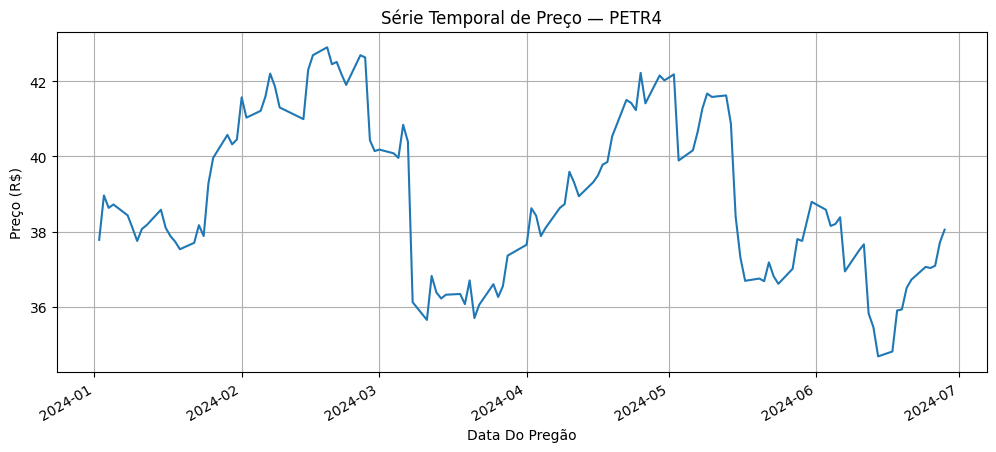

In [7]:
# ============================================================================
# BLOCO 2 — ANÁLISE EXPLORATÓRIA INICIAL
# ============================================================================

# Volatilidade (desvio padrão) por ativo
volatilidade = df.groupby("CODNEG")["PREULT_NORMALIZADO"].std().sort_values(ascending=False)
print("Top 10 ativos mais voláteis:")
print(volatilidade.head(10))

# Preço médio por ativo
preco_medio = df.groupby("CODNEG")["PREULT_NORMALIZADO"].mean()
print("\nPreço médio de PETR4:")
print(preco_medio.loc["PETR4"])

# Seleção de ativo exemplo
ativo_exemplo = "PETR4"
df_ativo = df_fechamento[[ativo_exemplo]].dropna()

# Série temporal básica
plt.figure(figsize=(12, 5))
df_ativo[ativo_exemplo].plot()
plt.title(f"Série Temporal de Preço — {ativo_exemplo}")
plt.ylabel("Preço (R$)")
plt.grid(True)
plt.show()

Depois de entender o comportamento isolado da PETR4, o próximo passo foi comparar esse ativo com o mercado como um todo.
Para isso, eu uso o IBOVESPA como benchmark, que representa o desempenho médio das principais ações brasileiras.

(aponta para as duas linhas do gráfico)

Nesse gráfico, a linha azul representa a PETR4 e a linha laranja representa o IBOVESPA.
Ambas começam na mesma base, que é o valor 100, justamente para permitir uma comparação direta de desempenho ao longo do tempo.

(explica o conceito central)

Quando a linha da PETR4 está acima da linha do IBOV, significa que a ação está performando melhor que o mercado.
Quando está abaixo, ela está tendo um desempenho inferior ao índice.

(interpretação visual rápida)

Ao longo do período analisado, é possível observar momentos em que a PETR4 supera claramente o IBOV, mas também períodos em que ela apresenta quedas mais acentuadas do que o mercado.
Isso indica que a PETR4 tem um comportamento mais volátil, amplificando tanto ganhos quanto perdas em relação ao índice.

(fecha o bloco)

Esse tipo de comparação é fundamental para avaliar se um ativo realmente agrega valor em relação ao mercado ou se apenas acompanha o movimento geral.

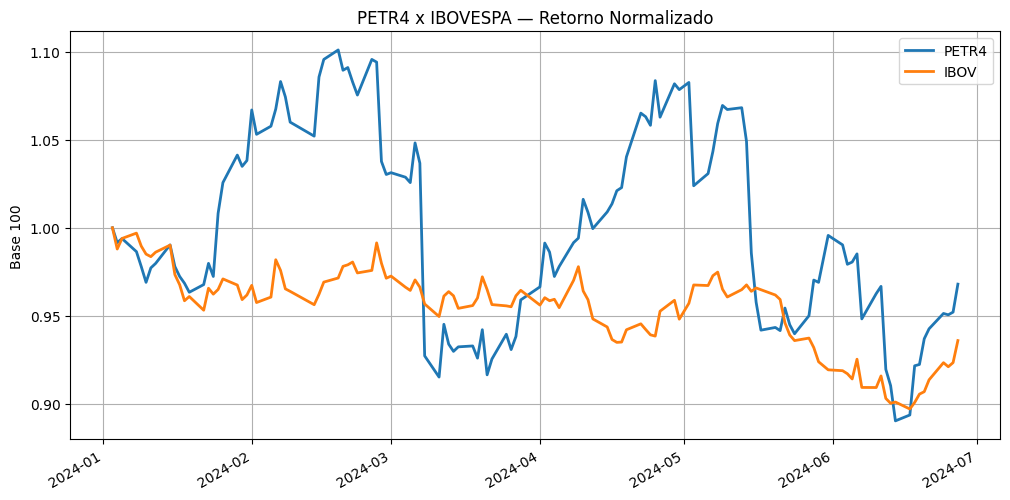

In [8]:
# ============================================================================
# BLOCO 3 — DINÂMICA DE MERCADO E BENCHMARK
# ============================================================================

data_ini, data_fim = df_fechamento.index.min(), df_fechamento.index.max()

# Download do IBOVESPA
ibov_data = yf.download("^BVSP", start=data_ini, end=data_fim, progress=False)

# Tratamento do formato retornado
if isinstance(ibov_data.columns, pd.MultiIndex):
    ibov_data.columns = ibov_data.columns.get_level_values(0)

ibov = ibov_data["Close"]

# DataFrame comparativo
df_bench = pd.DataFrame({
    "PETR4": df_fechamento["PETR4"],
    "IBOV": ibov
}).dropna()

# Retornos diários
retornos = df_bench.pct_change().dropna()

# Retorno acumulado normalizado
ret_acum = (1 + retornos).cumprod()
ret_acum /= ret_acum.iloc[0]

# Plot
ret_acum.plot(figsize=(12, 6), linewidth=2)
plt.title("PETR4 x IBOVESPA — Retorno Normalizado")
plt.ylabel("Base 100")
plt.grid(True)
plt.show()

“Depois de entender o comportamento geral do preço e comparar o ativo com o mercado, eu passo para uma análise mais específica do movimento do preço usando indicadores técnicos.”

RSI — Índice de Força Relativa (gráfico de cima)

“Esse primeiro gráfico mostra o RSI, que é um indicador de momentum.
Ele mede a força do movimento do preço ao longo do tempo, variando de 0 a 100.”

“Essas duas linhas tracejadas são referências importantes:

A linha vermelha em 70 indica regiões de sobrecompra, onde o preço pode estar esticado para cima.

A linha verde em 30 indica regiões de sobrevenda, onde o preço pode estar excessivamente pressionado para baixo.”

“O que a gente observa aqui é que o preço da PETR4 oscila bastante entre essas faixas.
Sempre que o RSI se aproxima de 70, o movimento de alta começa a perder força.
E quando se aproxima de 30, surgem momentos em que o preço tende a reagir.”

“Ou seja, o RSI não prevê o futuro, mas ajuda a identificar possíveis excessos do mercado.”

_________________________________________________________________________________________________________________________________

📈 Bandas de Bollinger (gráfico de baixo)

“Já nesse segundo gráfico, eu utilizo as Bandas de Bollinger, que ajudam a entender a volatilidade do preço.”

📈 O que observar no gráfico (apontando com o dedo)

“Quando o preço (linha azul) se aproxima da banda superior, isso indica que ele está relativamente alto em relação à sua média.”

“Quando o preço se aproxima da banda inferior, ele está relativamente baixo em relação ao comportamento recente.”

“Perceba também que, em alguns períodos, a distância entre a banda superior e a inferior aumenta.
Isso indica maior volatilidade, ou seja, o mercado está mais agitado.”

“Em outros momentos, esse canal fica mais estreito, indicando um período de menor volatilidade, com o preço oscilando menos.”

⚠️ Parte importante (sem prometer milagre)

“Essas bandas não dizem que o preço vai subir ou cair, mas ajudam a identificar regiões de excesso.”

“Elas mostram quando o preço está se afastando muito do padrão médio, o que pode indicar maior risco naquele momento.”


🎯 Mensagem certa para a banca

“O uso das Bandas de Bollinger aqui serve para analisar volatilidade e comportamento do preço, não para prever o mercado.”

“Elas complementam a análise estatística e ajudam a visualizar períodos de estresse e calmaria do ativo.”

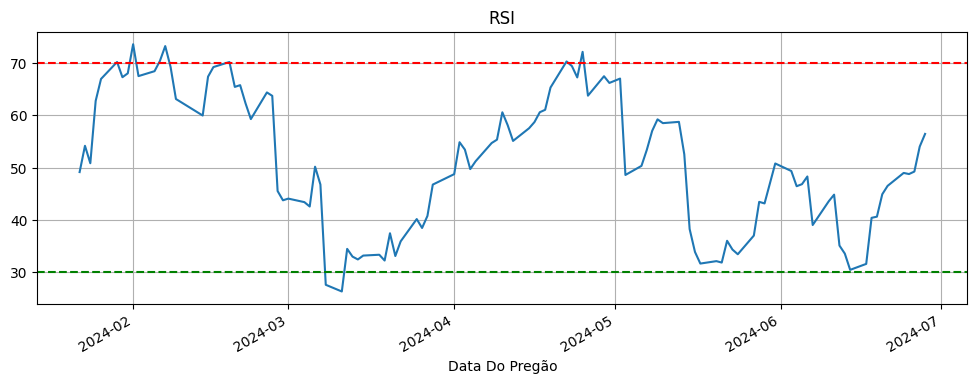

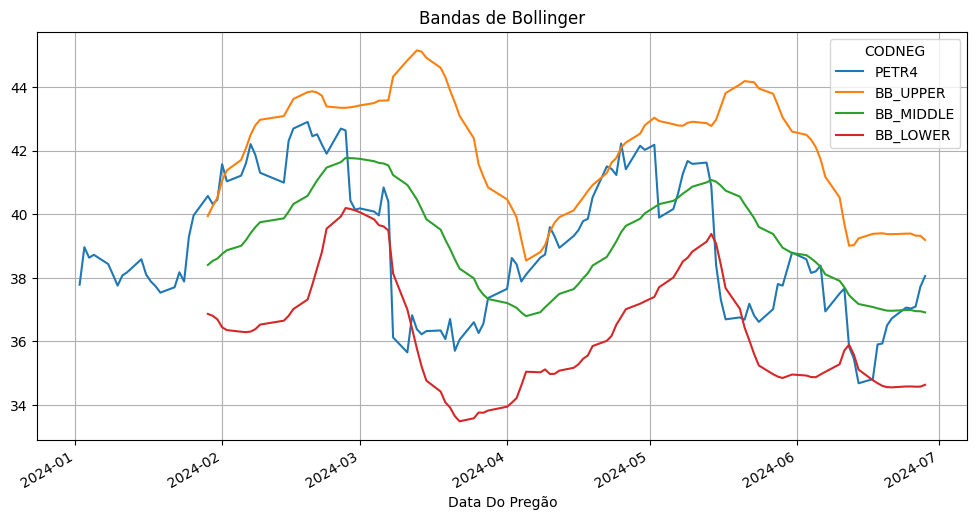

In [9]:
# ============================================================================
# BLOCO 4 — INDICADORES TÉCNICOS
# ============================================================================

df_ta = df_ativo.copy()
preco = df_ta[ativo_exemplo].values

df_ta["RSI"] = talib.RSI(preco, timeperiod=14)
upper, middle, lower = talib.BBANDS(preco, timeperiod=20)
df_ta["BB_UPPER"] = upper
df_ta["BB_MIDDLE"] = middle
df_ta["BB_LOWER"] = lower
df_ta["MACD"], _, _ = talib.MACD(preco)

# RSI
plt.figure(figsize=(12, 4))
df_ta["RSI"].plot(title="RSI")
plt.axhline(70, color="red", linestyle="--")
plt.axhline(30, color="green", linestyle="--")
plt.grid(True)
plt.show()

# Bandas de Bollinger
df_ta[[ativo_exemplo, "BB_UPPER", "BB_MIDDLE", "BB_LOWER"]].plot(figsize=(12, 6))
plt.title("Bandas de Bollinger")
plt.grid(True)
plt.show()

“Até aqui, eu mostrei como o preço se comporta ao longo do tempo e usei alguns indicadores para entender momentos de força e fraqueza do ativo.”

“Agora, eu passo para uma etapa mais numérica, onde eu tento responder a seguinte pergunta:
👉 quanto esse ativo rende e quão arriscado ele é?”

“Para fazer isso, eu não analiso mais o preço diretamente, mas sim as variações de preço de um dia para o outro, que chamamos de retornos diários.”

“Esses retornos mostram, por exemplo, se o ativo subiu 1%, caiu 2% ou ficou estável em cada dia.”

📊 Conectando com o que o código faz (sem jargão)

“A partir desses retornos, eu calculo três coisas:”

“O retorno médio anual, que indica quanto o ativo tende a render ao longo de um ano.”

“A volatilidade, que mede o quanto esse retorno varia — em outras palavras, o nível de risco.”

“E o Sharpe Ratio, que junta essas duas informações para mostrar se o retorno compensa o risco.”




### Dados na tabela 

Esses ativos aparecem com valores nulos porque não possuem histórico suficiente de negociação no período analisado.
Como as métricas de risco dependem de variações consistentes ao longo do tempo, o modelo corretamente evita gerar resultados estatísticos inválidos.”

In [13]:
# ============================================================================
# BLOCO 5 — MÉTRICAS DE RISCO E RETORNO
# ============================================================================

df_retornos = df_fechamento.pct_change().dropna()

retorno_anual = df_retornos.mean() * 252
vol_anual = df_retornos.std() * np.sqrt(252)
taxa_rf = 0.10

sharpe = (retorno_anual - taxa_rf) / vol_anual

df_metricas = pd.DataFrame({
    "Retorno Anual": retorno_anual,
    "Volatilidade": vol_anual,
    "Sharpe Ratio": sharpe
}).sort_values("Sharpe Ratio", ascending=False)

print("Top 10 ativos por Sharpe Ratio:")
print(df_metricas.head(10))


Top 10 ativos por Sharpe Ratio:
        Retorno Anual  Volatilidade  Sharpe Ratio
CODNEG                                           
5GTK11            NaN           NaN           NaN
A1AP34            NaN           NaN           NaN
A1CR34            NaN           NaN           NaN
A1DI34            NaN           NaN           NaN
A1DM34            NaN           NaN           NaN
A1EE34            NaN           NaN           NaN
A1EG34            NaN           NaN           NaN
A1EN34            NaN           NaN           NaN
A1EP34            NaN           NaN           NaN
A1ES34            NaN           NaN           NaN


“Depois de analisar risco e retorno individualmente, eu avancei para uma abordagem um pouco diferente.”

“Aqui, ao invés de olhar cada ativo isoladamente, eu tentei entender quais ativos se comportam de forma parecida ao longo do tempo.”


In [14]:
# ============================================================================
# BLOCO 6 — CLUSTERING COM K-MEANS (ROBUSTO)
# Objetivo: agrupar ativos por padrão de retorno
# ============================================================================

# Preparação da matriz de preços
df_fechamento_preenchido = (
    df_fechamento.sort_index().ffill().bfill()
)

df_retornos = df_fechamento_preenchido.pct_change().dropna(how="all")

🧠 O QUE É O CLUSTERING (SEM JARGÃO)

“Para isso, eu usei uma técnica de aprendizado de máquina chamada K-Means.”

“O objetivo não é prever preços, mas agrupar ativos com padrões semelhantes de retorno diário.”

“Ou seja, ativos que sobem e descem de maneira parecida tendem a cair no mesmo grupo.”

In [16]:
min_obs = 30
ativos_validos = df_retornos.count()
ativos_validos = ativos_validos[ativos_validos >= min_obs].index

df_retornos_filtrado = df_retornos[ativos_validos]

In [13]:
X = df_retornos_filtrado.T.fillna(0).to_numpy()
X.shape

(2047, 123)

O QUE O CÓDIGO FAZ (EM LINGUAGEM HUMANA)

“Primeiro, eu garanti que os dados estivessem completos, preenchendo eventuais lacunas de preço.”

“Depois, transformei os preços em retornos diários e selecionei apenas ativos com um histórico mínimo de observações, para evitar distorções.”

“Cada ativo passa a ser representado por uma sequência de retornos ao longo do tempo.”

📊 APONTANDO PARA O RESULTADO NA TELA

“Aqui, o algoritmo agrupou 2.047 ativos em 5 clusters.”

“O que chama atenção é que a grande maioria dos ativos ficou concentrada em um único cluster, enquanto alguns poucos ficaram isolados em clusters menores.”

# 🎯 CONCLUSÃO FORTE (ESSA É A CHAVE)

“Esse resultado é bastante comum em dados financeiros, porque muitos ativos tendem a se mover junto com o mercado, enquanto poucos têm comportamentos realmente distintos.”

“Do ponto de vista prático, isso ajuda a identificar:

ativos redundantes,

ativos com comportamento atípico,

e potenciais candidatos para diversificação de carteira.”

In [14]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = pd.Series(
    kmeans.fit_predict(X),
    index=df_retornos_filtrado.columns
)

clusters.value_counts()

4    2041
3       3
2       1
0       1
1       1
Name: count, dtype: int64

Depois de analisar o comportamento do preço, os indicadores técnicos e os padrões entre os ativos, eu incluí uma abordagem mais simples de modelagem estatística.”

“Aqui, eu utilizo regressão linear, não como previsão de mercado, mas como uma forma de identificar a tendência geral do preço ao longo do tempo.”

“É importante deixar claro que isso não é um modelo preditivo de mercado.”

“A regressão linear serve apenas para responder a uma pergunta básica:
👉 no longo prazo, o preço apresenta uma tendência de alta, de queda ou é estável?”

No gráfico, a linha azul representa o preço real da ação PETR4 ao longo do tempo.”

“Já a linha tracejada representa a linha de regressão linear, que resume todo esse movimento em uma tendência média.”

#### grafico

Mesmo com várias oscilações de curto prazo, a regressão ajuda a visualizar o direcionamento geral do preço.”

“Neste caso, a inclinação da linha sugere uma leve tendência de queda ao longo do período analisado, apesar das recuperações intermediárias.”


###### 🎯 CONEXÃO COM O RESTO DO TRABALHO

“Enquanto os indicadores técnicos analisam movimentos de curto prazo, a regressão linear oferece uma visão macroscópica, ajudando a entender o cenário geral.”

“Isso é especialmente útil em um contexto acadêmico, para mostrar como diferentes ferramentas respondem a perguntas diferentes sobre os mesmos dados.”

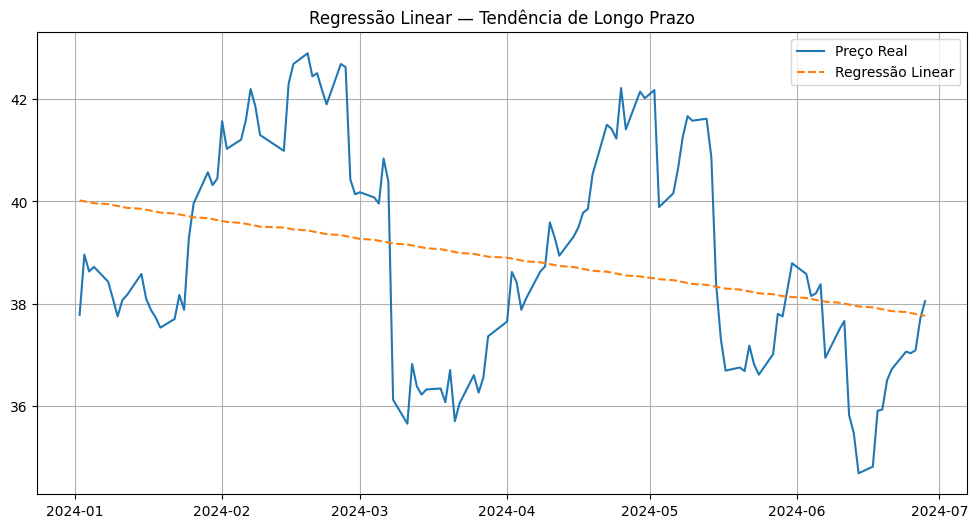

In [9]:
# ============================================================================
# BLOCO 7 — REGRESSÃO LINEAR (TENDÊNCIA)
# ============================================================================

df_reg = df_ativo.reset_index()
df_reg["t"] = np.arange(len(df_reg))

X = df_reg[["t"]]
y = df_reg[ativo_exemplo]

modelo = LinearRegression()
modelo.fit(X, y)

df_reg["Tendência"] = modelo.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(df_reg["Data Do Pregão"], y, label="Preço Real")
plt.plot(df_reg["Data Do Pregão"], df_reg["Tendência"], label="Regressão Linear", linestyle="--")
plt.title("Regressão Linear — Tendência de Longo Prazo")
plt.legend()
plt.grid(True)
plt.show()

Depois de analisar o preço pontualmente, os indicadores técnicos e a tendência geral, eu passo agora para uma abordagem de séries temporais.”

“Aqui, a ideia não é prever o futuro, mas entender como o passado influencia o comportamento do preço ao longo do tempo.”

Nesse gráfico, a linha azul representa o preço diário da PETR4.”

“As outras duas linhas são médias móveis, que são ferramentas clássicas em análise de séries temporais.”

“A média móvel de 20 dias representa o comportamento de curto prazo.”

“Já a média móvel de 50 dias representa uma visão mais suavizada e de longo prazo do preço.”

“Essas médias funcionam como filtros: elas reduzem o ‘ruído’ diário do mercado e ajudam a visualizar tendências.”

Quando o preço fica acima das médias, isso indica um momento de força.”

“Quando ele fica abaixo, sugere um período de fraqueza relativa.”

“Os cruzamentos entre essas médias também ajudam a identificar mudanças de tendência, mas sempre de forma indicativa, não determinística.”

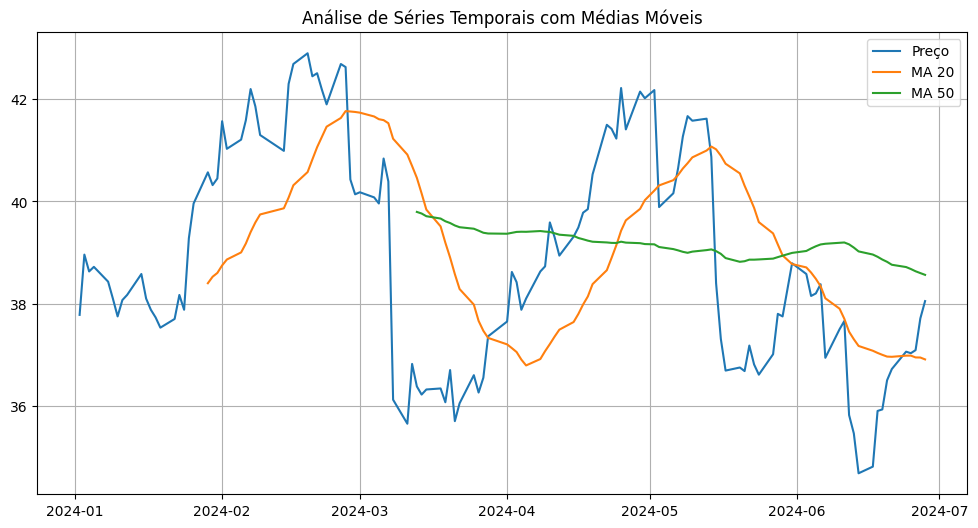

In [7]:
# ============================================================================
# BLOCO 8 — SÉRIES TEMPORAIS
# ============================================================================

# Médias móveis
df_ts = df_ativo.copy()
df_ts["MA_20"] = df_ts[ativo_exemplo].rolling(20).mean()
df_ts["MA_50"] = df_ts[ativo_exemplo].rolling(50).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_ts[ativo_exemplo], label="Preço")
plt.plot(df_ts["MA_20"], label="MA 20")
plt.plot(df_ts["MA_50"], label="MA 50")
plt.title("Análise de Séries Temporais com Médias Móveis")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# ============================================================================
# BLOCO FINAL — SÍNTESE DE INVESTIMENTO (CONSISTÊNCIA + RISCO)
# ============================================================================

min_obs = 60
taxa_rf = 0.10

# Ativos com histórico suficiente
ativos_validos = (
    df_retornos.count()[df_retornos.count() >= min_obs]
).index

df_ret = df_retornos[ativos_validos]

# Frequência de retornos positivos
freq_positiva = (df_ret > 0).mean()

# Retorno e risco
retorno_anual = df_ret.mean() * 252
vol_anual = df_ret.std() * np.sqrt(252)
sharpe = (retorno_anual - taxa_rf) / vol_anual

# Perda média nos dias negativos
perda_media = df_ret[df_ret < 0].mean().abs()

# Consolidação final
df_final = pd.DataFrame({
    "Frequência de Retornos Positivos": freq_positiva,
    "Sharpe Ratio": sharpe,
    "Perda Média em Dias Negativos": perda_media
}).dropna()

# Ranking final
df_final = df_final.sort_values(
    by=["Sharpe Ratio", "Frequência de Retornos Positivos"],
    ascending=False
)

print("\n🔎 Top 10 Ativos Mais Consistentes (Histórico):\n")
print(df_final.head(10))


🔎 Top 10 Ativos Mais Consistentes (Histórico):

        Frequência de Retornos Positivos  Sharpe Ratio  \
CODNEG                                                   
B1SX34                          0.528455      4.266637   
L1DO34                          0.552846      4.050576   
USAL11                          0.544715      3.846771   
S2EA34                          0.593496      3.795731   
IVVB11                          0.601626      3.757296   
SPXI11                          0.585366      3.694076   
ESGU11                          0.552846      3.666116   
GENB11                          0.593496      3.584382   
BOEF39                          0.227642      3.568720   
COWC34                          0.634146      3.567259   

        Perda Média em Dias Negativos  
CODNEG                                 
B1SX34                       0.007450  
L1DO34                       0.006929  
USAL11                       0.004852  
S2EA34                       0.016956  
IVVB11        